In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
%matplotlib notebook
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry

import traveltimepy as ttpy
import os
from datetime import datetime #for examples
#TODO: store credentials in an environment variable
os.environ["TRAVELTIME_ID"] = '466b4c75'
os.environ["TRAVELTIME_KEY"] = 'aa473fed8d8638f1b576305a7e1fc019'

In [2]:
#Load Maersk Data
df = pd.read_excel(r'maersk2022deliveries.xlsx', sheet_name='Data')
df['PC_Area'] = df['Post Code'].str.extract(r'(^[a-zA-Z][a-zA-Z]?)')
df.head()

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area
0,2022,1,GBBFSTM,E,20,DRY,BT3,BELFAST NORTHERN IRE,S-TRUCK,5,BT3,BT
1,2022,1,GBBFSTM,E,20,DRY,BT66,CRAIGAVON NORTHERN I,S-TRUCK,1,BT66,BT
2,2022,1,GBBFSTM,E,20,DRY,BT78,OMAGH NORTHERN IRELA,S-TRUCK,1,BT78,BT
3,2022,1,GBBFSTM,E,40,DRY,BT66,CRAIGAVON NORTHERN I,S-TRUCK,1,BT66,BT
4,2022,1,GBBFSTM,E,40,HIGH,BT36,NEWTOWNABBEY NORTHER,S-TRUCK,1,BT36,BT


In [3]:
#Set up Freightliner locations
data = [['FL Leeds', 53.7673, -1.5062], ['FL Doncaster', 53.508157, -1.125958]]
  
# Create the pandas DataFrame
fl_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long'])  

# print dataframe.
fl_locations

# creating a geometry column 
geometry = [Point(xy) for xy in zip(fl_locations['Long'], fl_locations['Lat'])]
# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
fl_points = gpd.GeoDataFrame(fl_locations, crs=crs, geometry=geometry)

indexed_fl_points = fl_points.set_index('Terminal')
indexed_fl_points

,Lat,Long,geometry
Terminal,,,
FL Leeds,53.767300,-1.506200,POINT (-1.50620 53.76730)
FL Doncaster,53.508157,-1.125958,POINT (-1.12596 53.50816)


In [4]:
#Inclusion & Exclusion Criteria
#Only include Dry and High containers
#Include only North East Post Code Areas
direction_included = ['I', 'E']
type_included = ['DRY', 'HIGH', 'REEF']
Postcode_excluded = ['EIRE']
Mode_included = ['S-TRAIN', 'C-TRAIN']
areas_excluded = ['SA', 'SK', 'SN','SO','SP', 'ST','SY']
north_east=['LS','WF','HD', 'HG', 'S', 'HX', 'BD', 'DN', 'LN', 'NG', 'HU', 'YO', 'DL', 'TS', 'SR', 'DH', 'NE', 'DE']
slice = df[(df.Mode.str.match('|'.join(Mode_included))) &~(df.PC_Area.str.match('|'.join(areas_excluded))) & (df.PC_Area.str.match('|'.join(north_east))) & df.Direction.str.match('|'.join(direction_included)) & (df.Type.str.match('|'.join(type_included))) & ~(df.Postcode_clean.str.match('|'.join(Postcode_excluded)))]

In [5]:
#Check for match on S that was including PostCode Areas that started with S due to Sheffield
slice[slice.PC_Area.str.match('S')].groupby('PC_Area')['Units'].sum()

PC_Area
S     7606
SR     157
Name: Units, dtype: int64

# Postcode District Level Analysis (e.g., LN10)

<IPython.core.display.Javascript object>


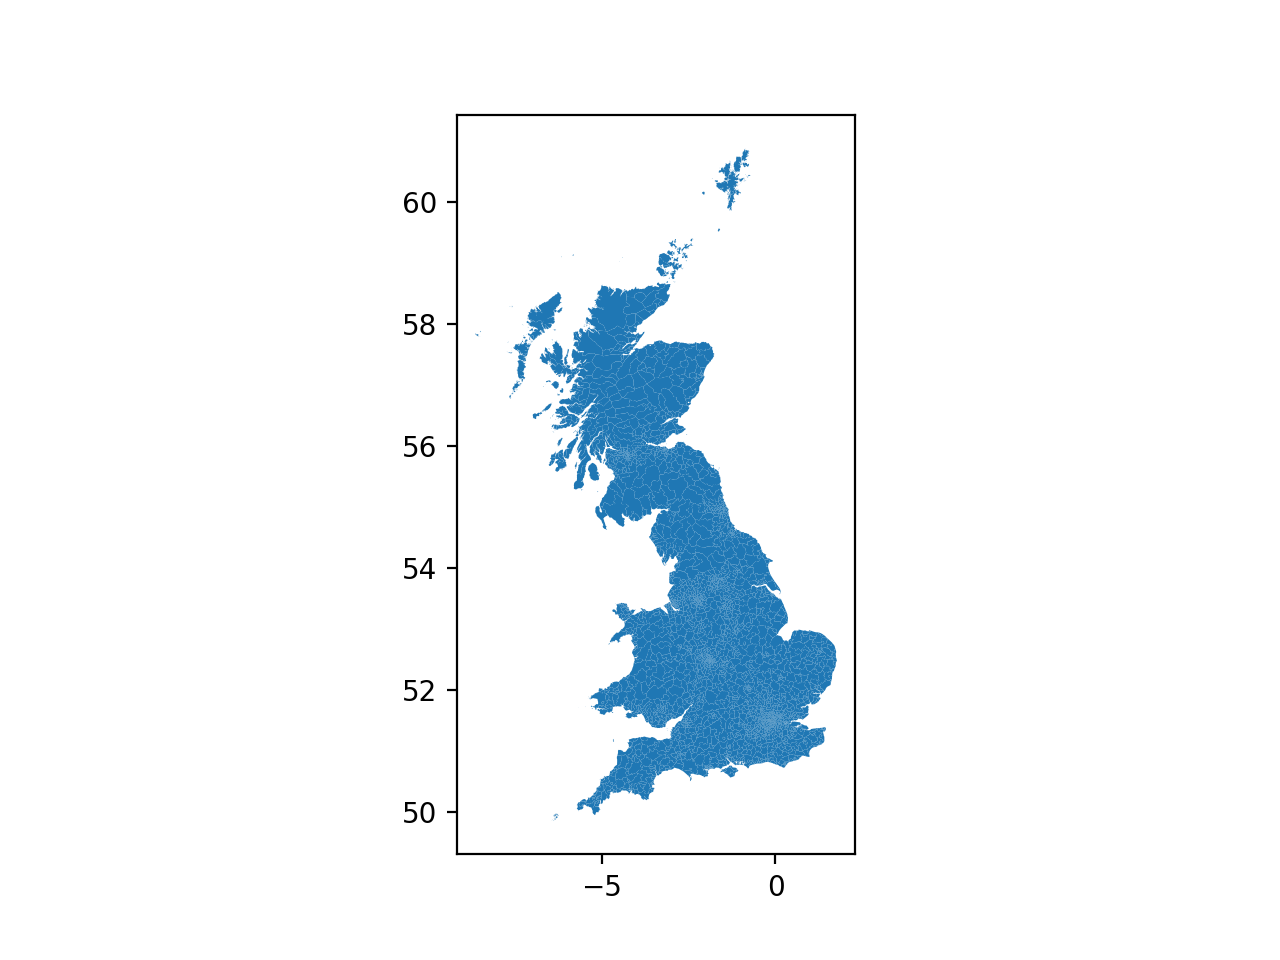

<AxesSubplot: >

In [6]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()


In [7]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [8]:
#Aggregate postcodes with total containers for the year
aggregate_district = slice[slice.Direction.str.match('|'.join(['I', 'E']))].groupby(["Postcode_clean"])["Units"].sum().reset_index()
sorted_area = aggregate_district.sort_values(by = "Units", ascending = 0).head(20)
sorted_area['Annualised_Units'] = sorted_area['Units'] / 8 * 12
sorted_area['Unit_pct'] = sorted_area.Units / df.Units.sum()
sorted_area.style.format({
    'Annualised_Units': '{:,.0f}'.format,
    'Unit_pct': '{:,.1%}'.format,
})

#TODO: Annualise & Give Monthly Average Units

,Postcode_clean,Units,Annualised_Units,Unit_pct
250,S9,4191,"6,286",2.6%
269,TS6,1364,"2,046",0.9%
85,DN40,1221,"1,832",0.8%
248,S80,1192,"1,788",0.8%
67,DN11,1135,"1,702",0.7%
271,WF10,993,"1,490",0.6%
266,TS25,973,"1,460",0.6%
272,WF11,842,"1,263",0.5%
25,DE14,797,"1,196",0.5%
278,WF17,744,"1,116",0.5%


In [9]:
reset_index = map_df.set_index("name")
merged = reset_index.join(aggregate_district.set_index("Postcode_clean"))
merged["Units"] = merged["Units"].fillna(0)
merged

,geometry,Units
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


<IPython.core.display.Javascript object>


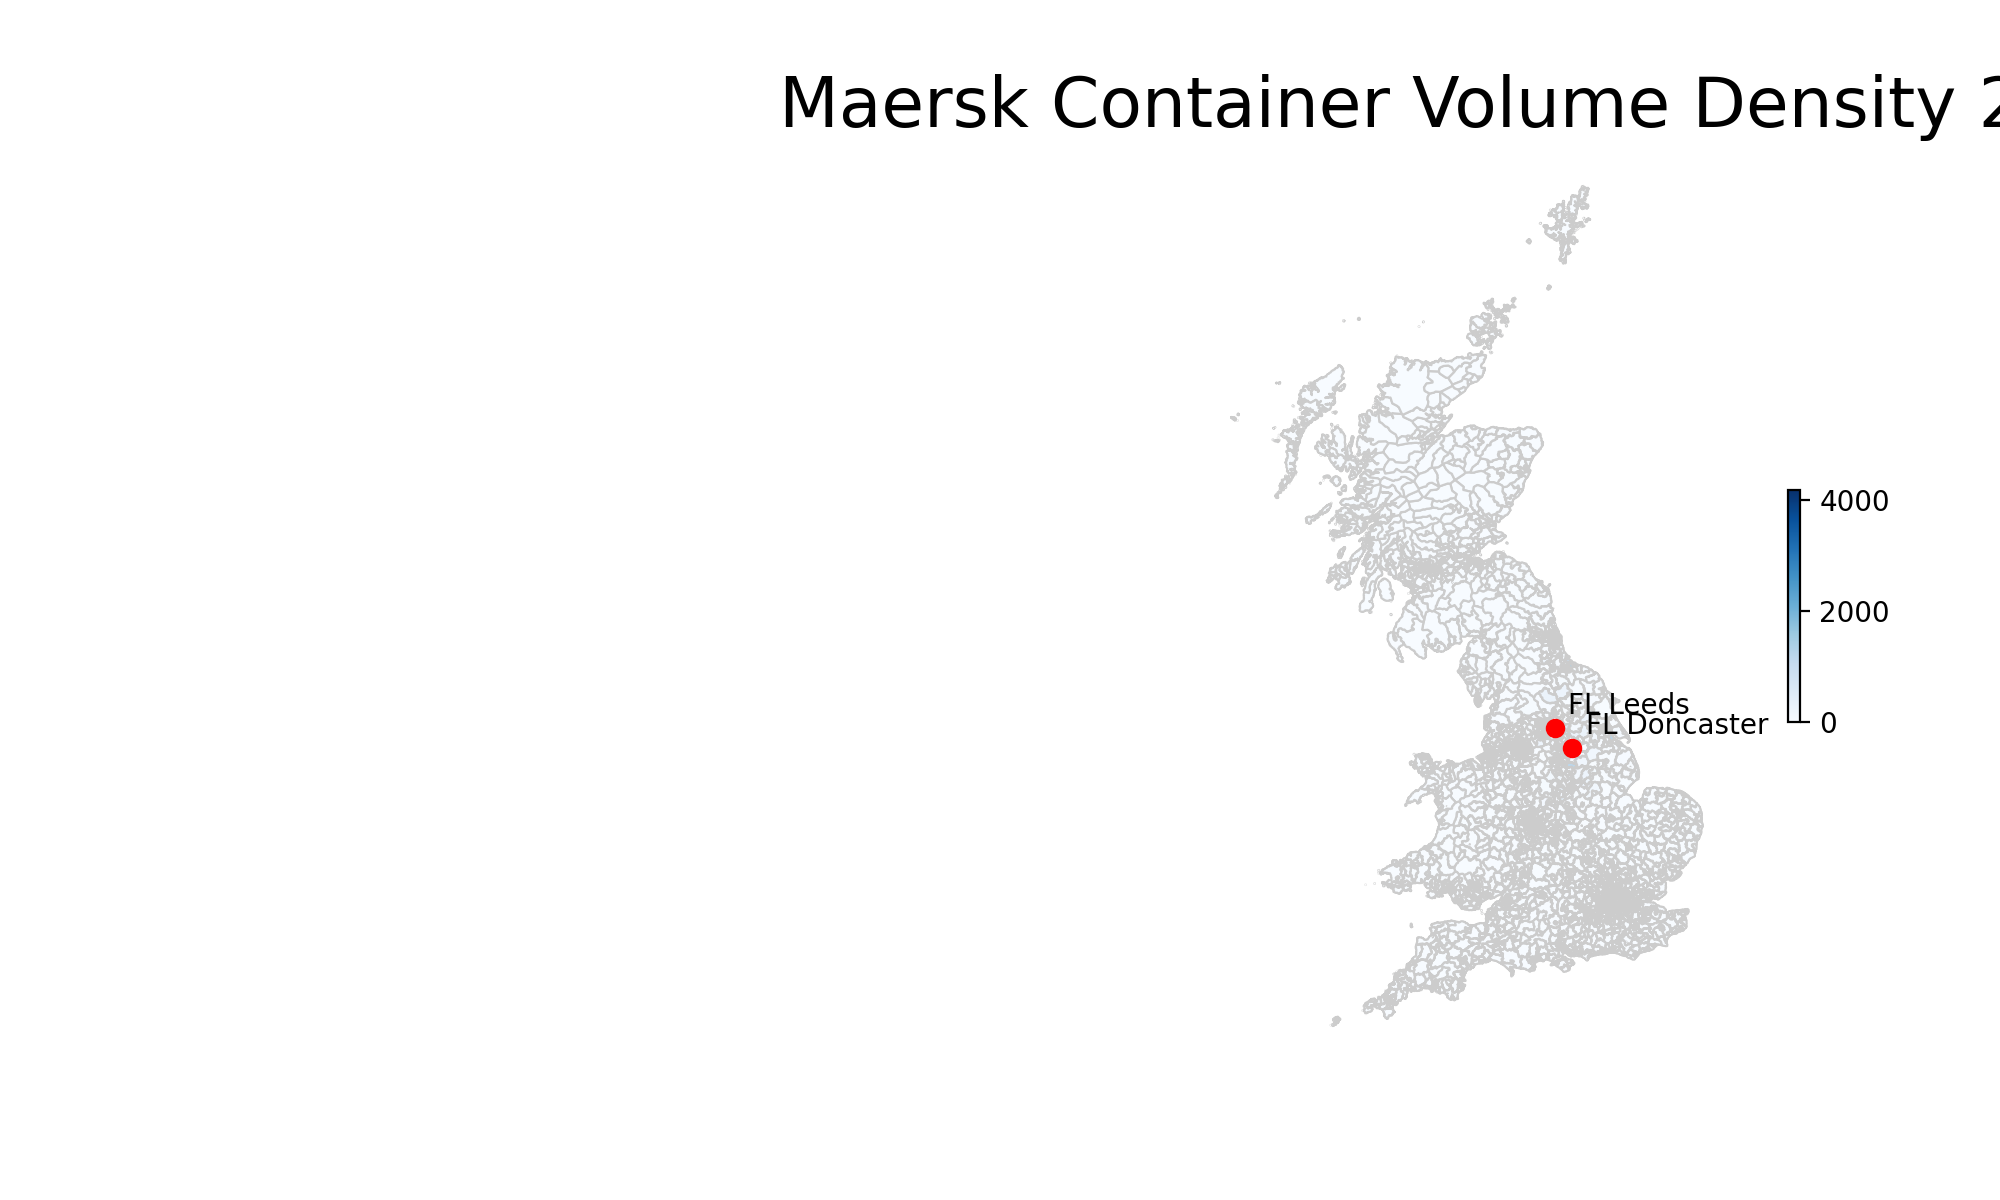

/var/folders/4r/y80n195n7bzf_nd0xqdjksd80000gn/T/ipykernel_47744/3430273432.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


<AxesSubplot: title={'center': 'Maersk Container Volume Density 2022'}>

In [10]:
variable = "Units"
vmin, vmax = 0, merged.Units.max()
fig, ax = plt.subplots(1, figsize=(10, 6))

# add a title and remove axis
ax.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("FL Leeds", (indexed_fl_points.loc["FL Leeds"]["Long"], indexed_fl_points.loc["FL Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("FL Doncaster", (indexed_fl_points.loc["FL Doncaster"]["Long"], indexed_fl_points.loc["FL Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
fl_points.plot(ax=ax, color="red")



# Postcode Area-level analysis (e.g., LN)

<IPython.core.display.Javascript object>


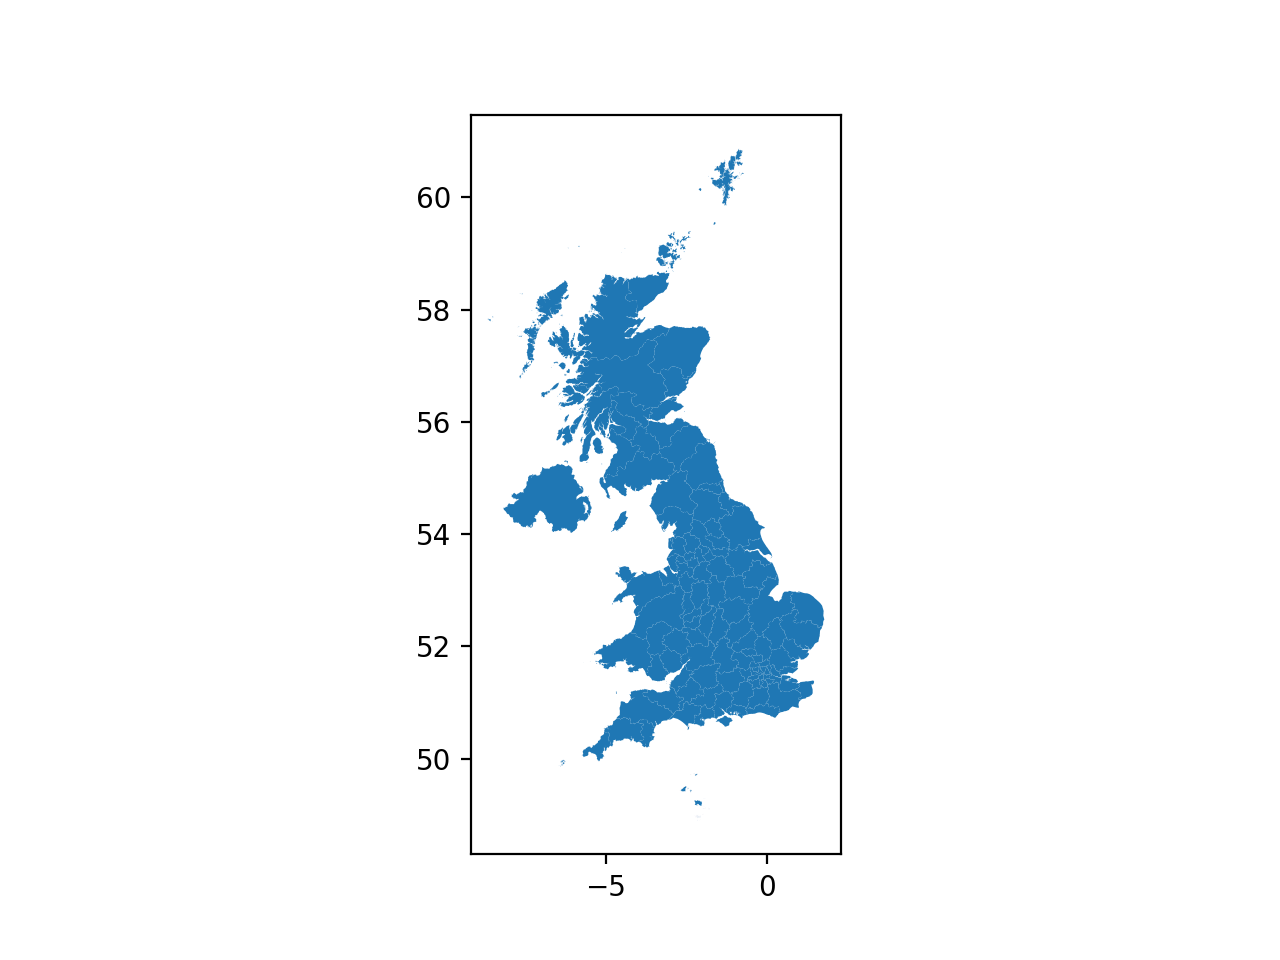

<AxesSubplot: >

In [11]:
#Load and check map of PostCode Districts
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()

In [12]:
# Create Column with Postcode Area (one or two letters)
area_df = slice[slice.Direction.str.match('|'.join(['I']))]

In [13]:
#Aggregate postcodes with total containers for the year
aggregate_area = area_df.groupby(["PC_Area"])["Units"].sum().reset_index()
aggregate_area.describe()

,Units
count,18.000000
mean,824.277778
std,1385.151672
min,58.000000
25%,130.250000
50%,284.500000
75%,636.500000
max,5707.000000


In [14]:
reset_index = map_df_areas.set_index("name")
merged_area = reset_index.join(aggregate_area.set_index("PC_Area"))
merged_area["Units"] = merged_area["Units"].fillna(0)
merged_area.sort_values(by="Units", ascending=False)

,geometry,Units
name,,
S,"POLYGON ((-1.40349 53.15248, -1.40379 53.15263...",5707.0
WF,"POLYGON ((-1.48096 53.74180, -1.48031 53.74136...",2443.0
DN,"MULTIPOLYGON (((-0.66481 53.70417, -0.66475 53...",1596.0
TS,"POLYGON ((-0.73513 54.52823, -0.73570 54.52699...",1527.0
BD,"POLYGON ((-1.80510 53.76131, -1.80517 53.76137...",668.0
...,...,...
GU,"MULTIPOLYGON (((-0.41590 51.16293, -0.41573 51...",0.0
GL,"POLYGON ((-2.60209 51.67321, -2.60773 51.67868...",0.0
G,"MULTIPOLYGON (((-4.87091 56.10131, -4.86951 56...",0.0


<IPython.core.display.Javascript object>


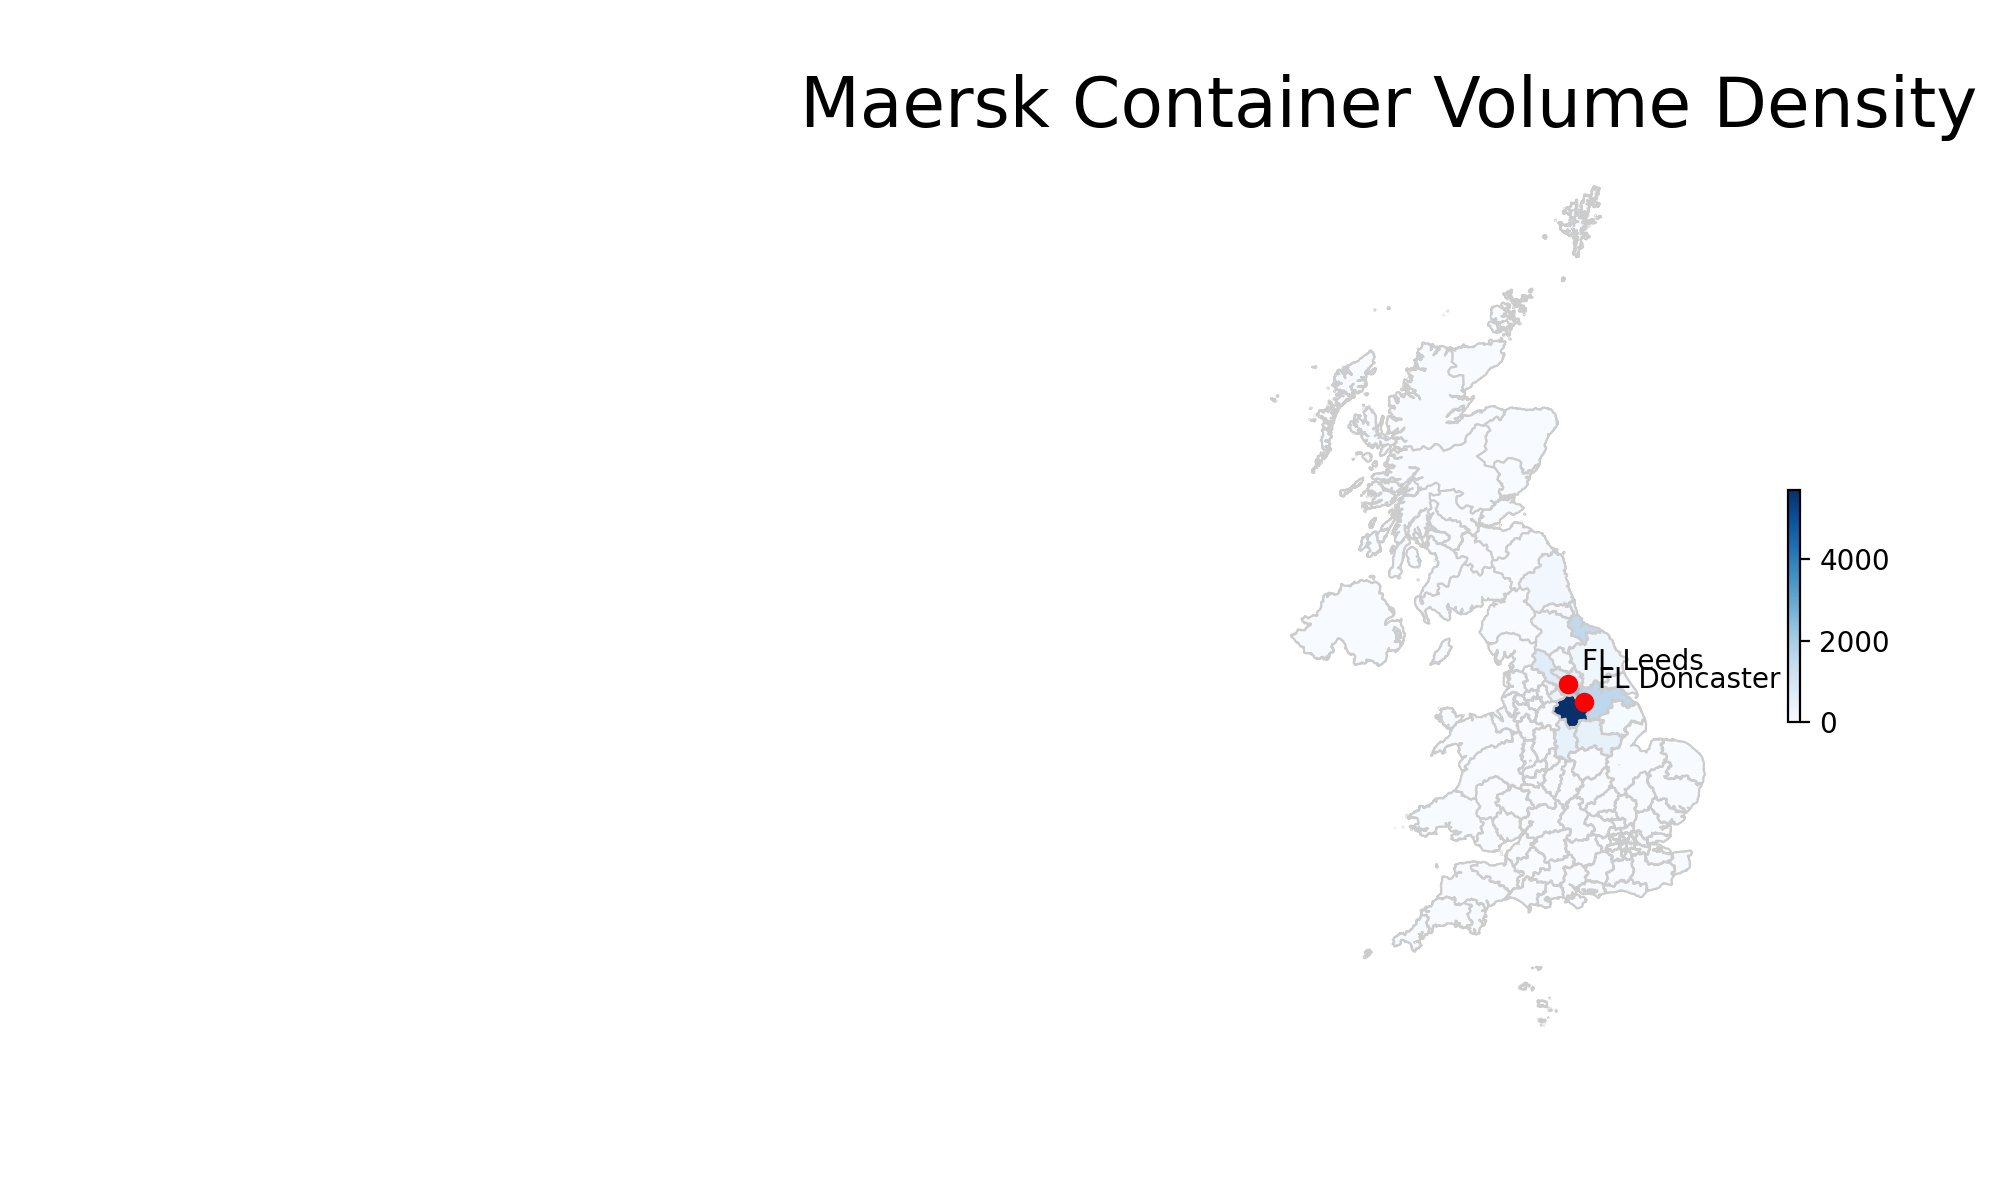

/var/folders/4r/y80n195n7bzf_nd0xqdjksd80000gn/T/ipykernel_47744/1306329830.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)


<AxesSubplot: title={'center': 'Maersk Container Volume Density 2022'}>

In [15]:
fig_com, ax_com = plt.subplots(1, figsize=(10, 6))
ax_com.axis('off')
vmin_area, vmax_area = 0, merged_area.Units.max()

# add a title
ax_com.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_area, vmax=vmax_area))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)

ax_com.annotate("FL Leeds", (indexed_fl_points.loc["FL Leeds"]["Long"], indexed_fl_points.loc["FL Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("FL Doncaster", (indexed_fl_points.loc["FL Doncaster"]["Long"], indexed_fl_points.loc["FL Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")

merged_area.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax_com, edgecolor='0.8') 
fl_points.plot(ax=ax_com, color="red")

# Haulier Analysis

In [16]:
postcode_latlong = pd.read_csv(r'postcode-outcodes.csv')
postcode_latlong

,id,postcode,latitude,longitude
0,1,B34,52.496413,-1.781704
1,2,IP10,52.018977,1.269990
2,3,G2,55.862907,-4.256159
3,4,GL19,51.946158,-2.290968
4,5,L36,53.414406,-2.841731
...,...,...,...,...
2946,2947,WV5,52.534108,-2.210337
2947,2948,PL23,50.337453,-4.636803
2948,2949,TR12,50.042234,-5.179442
2949,2950,S96,53.402359,-1.425062


In [17]:
df2 = slice
df3 = pd.merge(left=df2, right=postcode_latlong, how="inner", left_on="Postcode_clean", right_on="postcode")
df3 = df3.drop(columns=['id', 'postcode'])
df3

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude
0,2022,1,GBFXSTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534
1,2022,1,GBFXSTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,4,BD1,BD,53.796662,-1.754534
2,2022,1,GBLGPTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534
3,2022,1,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534
4,2022,2,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,3,BD1,BD,53.796662,-1.754534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,2022,8,GBFXSTM,I,40,HIGH,NE27,NEWCASTLE UPON TYNE,C-TRAIN,1,NE27,NE,55.032950,-1.514982
4478,2022,8,GBFXSTM,I,40,HIGH,DE75,DERBY,C-TRAIN,2,DE75,DE,53.013072,-1.354307
4479,2022,8,GBFXSTM,I,40,HIGH,NE63,ASHINGTON NORTHUMBER,C-TRAIN,1,NE63,NE,55.178227,-1.563273
4480,2022,8,GBFXSTM,I,40,HIGH,S2 3,SHEFFIELD,C-TRAIN,2,S2,S,53.369613,-1.448005


In [18]:
df4 = df3.groupby(["Postcode_clean"])["Units"].sum().reset_index()
df5 = pd.merge(left=df4, right=postcode_latlong, how="inner", left_on="Postcode_clean", right_on="postcode")
df5 = df5.drop(columns=['id', 'postcode'])
df5

,Postcode_clean,Units,latitude,longitude
0,BD1,55,53.796662,-1.754534
1,BD11,1,53.752252,-1.675708
2,BD12,76,53.745682,-1.762659
3,BD13,3,53.786747,-1.861284
4,BD16,14,53.848451,-1.833134
...,...,...,...,...
299,YO60,3,54.086101,-0.938950
300,YO61,8,54.117929,-1.196024
301,YO62,2,54.246175,-0.994339
302,YO7,223,54.224686,-1.351425


In [19]:
locations = []
arrival_location_ids = df5['Postcode_clean']
for location in fl_points['Terminal']:
    data={"id": location, "coords": {"lat": fl_points[fl_points['Terminal'].str.contains(location)]["Lat"].iloc[0], 'lng': fl_points[fl_points['Terminal'].str.contains(location)]["Long"].iloc[0]}}
    locations.append(data)
    
for location in arrival_location_ids:
    data={"id": location, "coords": {"lat": df5[df5['Postcode_clean'].str.match(location)]["latitude"].iloc[0], 'lng': df5[df5['Postcode_clean'].str.match(location)]["longitude"].iloc[0]}}
    locations.append(data)

locations

[{'id': 'FL Leeds', 'coords': {'lat': 53.7673, 'lng': -1.5062}},
 {'id': 'FL Doncaster', 'coords': {'lat': 53.508157, 'lng': -1.125958}},
 {'id': 'BD1', 'coords': {'lat': 53.7966616, 'lng': -1.7545344}},
 {'id': 'BD11', 'coords': {'lat': 53.752252, 'lng': -1.6757083}},
 {'id': 'BD12', 'coords': {'lat': 53.7456818, 'lng': -1.7626592}},
 {'id': 'BD13', 'coords': {'lat': 53.7867466, 'lng': -1.8612838}},
 {'id': 'BD16', 'coords': {'lat': 53.8484508, 'lng': -1.8331337}},
 {'id': 'BD17', 'coords': {'lat': 53.8475875, 'lng': -1.768364}},
 {'id': 'BD18', 'coords': {'lat': 53.8304494, 'lng': -1.7768469}},
 {'id': 'BD19', 'coords': {'lat': 53.7273298, 'lng': -1.7141196}},
 {'id': 'BD2', 'coords': {'lat': 53.8152428, 'lng': -1.7344633}},
 {'id': 'BD20', 'coords': {'lat': 53.8982751, 'lng': -1.9501915}},
 {'id': 'BD21', 'coords': {'lat': 53.864231, 'lng': -1.9076629}},
 {'id': 'BD22', 'coords': {'lat': 53.8457607, 'lng': -1.9553752}},
 {'id': 'BD23', 'coords': {'lat': 53.993339, 'lng': -2.0569312}

In [20]:
combined_searches = []

In [21]:
#There was a problem with API limits that set max elements
#So we need go through in batches of 100 and process after

leeds_search = {
  "id": "Leeds",
  "departure_location_id": "FL Leeds",
  "arrival_location_ids": arrival_location_ids.tolist()[300:],
  "transportation": {"type": "driving"},
  "departure_time":  "2022-10-12T09:00:00Z",
  "travel_time": 4*60*60,
  "properties": ["travel_time", "distance"],
  "range": {"enabled": True, "max_results": 1, "width": 600}
}

doncaster_search = {
  "id": "Doncaster",
  "departure_location_id": "FL Doncaster",
  "arrival_location_ids": arrival_location_ids.tolist()[300:],
  "transportation": {"type": "driving"},
  "departure_time":  "2022-10-12T09:00:00Z",
  "travel_time": 4*60*60,
  "properties": ["travel_time", "distance"],
  "range": {"enabled": True, "max_results": 1, "width": 600}
}


#out_leeds = ttpy.time_filter(locations=locations, departure_searches=leeds_search)
#combined_searches.append(out_leeds)
#out_leeds

out_doncaster = ttpy.time_filter(locations=locations, departure_searches=doncaster_search)
combined_searches.append(out_doncaster)
out_doncaster

{'results': [{'search_id': 'Doncaster',
   'locations': [{'id': 'YO8',
     'properties': [{'travel_time': 2520, 'distance': 34719}]},
    {'id': 'YO61', 'properties': [{'travel_time': 4516, 'distance': 93152}]},
    {'id': 'YO62', 'properties': [{'travel_time': 5890, 'distance': 127952}]},
    {'id': 'YO7', 'properties': [{'travel_time': 4242, 'distance': 99433}]}],
   'unreachable': []}]}

In [22]:
leeds_distance_set = {}
doncaster_distance_set = {}

for x in combined_searches:
    origin = x['results'][0]['search_id']
    for y in x['results'][0]['locations']:
        if origin == 'Leeds':
            leeds_distance_set[y['id']] = y['properties'][0]['distance'] / 1.60934 / 1000
        if origin == 'Doncaster':
            doncaster_distance_set[y['id']] = y['properties'][0]['distance'] / 1.60934 / 1000


In [23]:
leeds_distance_set

{}

In [24]:
def check_leeds_distance(x):
    try:
        return leeds_distance_set[x]
    except:
        return None

def check_doncaster_distance(x):
    try:
        return doncaster_distance_set[x]
    except:
        return None

    
df6 = df3
df6['Leeds'] = df6['Postcode_clean'].apply(lambda x: check_leeds_distance(x))
df6['Doncaster'] = df6['Postcode_clean'].apply(lambda x: check_doncaster_distance(x))
df6

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude,Leeds,Doncaster
0,2022,1,GBFXSTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN
1,2022,1,GBFXSTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,4,BD1,BD,53.796662,-1.754534,None,NaN
2,2022,1,GBLGPTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN
3,2022,1,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN
4,2022,2,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,3,BD1,BD,53.796662,-1.754534,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,2022,8,GBFXSTM,I,40,HIGH,NE27,NEWCASTLE UPON TYNE,C-TRAIN,1,NE27,NE,55.032950,-1.514982,None,NaN
4478,2022,8,GBFXSTM,I,40,HIGH,DE75,DERBY,C-TRAIN,2,DE75,DE,53.013072,-1.354307,None,NaN
4479,2022,8,GBFXSTM,I,40,HIGH,NE63,ASHINGTON NORTHUMBER,C-TRAIN,1,NE63,NE,55.178227,-1.563273,None,NaN
4480,2022,8,GBFXSTM,I,40,HIGH,S2 3,SHEFFIELD,C-TRAIN,2,S2,S,53.369613,-1.448005,None,NaN


In [25]:
df7 = df6
df7["Leeds_band"] = df7['Leeds'] - df7['Leeds'].mod(10)
df7["Leeds_band"] = df7["Leeds_band"] / 10
df7["Doncaster_band"] = df7['Doncaster'] - df7['Doncaster'].mod(10) 
df7["Doncaster_band"] = df7["Doncaster_band"] / 10
df7

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude,Leeds,Doncaster,Leeds_band,Doncaster_band
0,2022,1,GBFXSTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN,NaN,NaN
1,2022,1,GBFXSTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,4,BD1,BD,53.796662,-1.754534,None,NaN,NaN,NaN
2,2022,1,GBLGPTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN,NaN,NaN
3,2022,1,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD,53.796662,-1.754534,None,NaN,NaN,NaN
4,2022,2,GBLGPTM,E,40,HIGH,BD1,BRADFORD YORKSHIRE,C-TRAIN,3,BD1,BD,53.796662,-1.754534,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,2022,8,GBFXSTM,I,40,HIGH,NE27,NEWCASTLE UPON TYNE,C-TRAIN,1,NE27,NE,55.032950,-1.514982,None,NaN,NaN,NaN
4478,2022,8,GBFXSTM,I,40,HIGH,DE75,DERBY,C-TRAIN,2,DE75,DE,53.013072,-1.354307,None,NaN,NaN,NaN
4479,2022,8,GBFXSTM,I,40,HIGH,NE63,ASHINGTON NORTHUMBER,C-TRAIN,1,NE63,NE,55.178227,-1.563273,None,NaN,NaN,NaN
4480,2022,8,GBFXSTM,I,40,HIGH,S2 3,SHEFFIELD,C-TRAIN,2,S2,S,53.369613,-1.448005,None,NaN,NaN,NaN


In [26]:
df7['Leeds'] = np.where(df7.Postcode_clean.str.match('DN10'),46.100000,df7.Leeds)
df7['Doncaster'] = np.where(df7.Postcode_clean.str.match('DN10'),14.10000000,df7.Doncaster)
df7["Leeds"] = pd.to_numeric(df7["Leeds"])
df7["Doncaster"] = pd.to_numeric(df7["Doncaster"])

In [27]:
df7["Leeds_band"] = df7['Leeds'] - df7['Leeds'].mod(10)
df7["Leeds_band"] = df7["Leeds_band"] / 10
df7["Doncaster_band"] = df7['Doncaster'] - df7['Doncaster'].mod(10) 
df7["Doncaster_band"] = df7["Doncaster_band"] / 10

In [28]:
df8 = df7
df8.sort_values(by='Leeds',ascending=False)

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude,Leeds,Doncaster,Leeds_band,Doncaster_band
3858,2022,1,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,2,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0
3859,2022,1,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0
3882,2022,8,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,10,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0
3881,2022,8,GBFXSTM,I,20,DRY,DN10,BAWTRY,C-TRAIN,5,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0
3880,2022,8,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,2022,8,GBFXSTM,I,40,HIGH,NE27,NEWCASTLE UPON TYNE,C-TRAIN,1,NE27,NE,55.032950,-1.514982,NaN,NaN,NaN,NaN
4478,2022,8,GBFXSTM,I,40,HIGH,DE75,DERBY,C-TRAIN,2,DE75,DE,53.013072,-1.354307,NaN,NaN,NaN,NaN
4479,2022,8,GBFXSTM,I,40,HIGH,NE63,ASHINGTON NORTHUMBER,C-TRAIN,1,NE63,NE,55.178227,-1.563273,NaN,NaN,NaN,NaN
4480,2022,8,GBFXSTM,I,40,HIGH,S2 3,SHEFFIELD,C-TRAIN,2,S2,S,53.369613,-1.448005,NaN,NaN,NaN,NaN


In [29]:
#Load in ONE haulage rates
#TODO: Change to Maersk Rates
rates = pd.read_excel(r'RoadTariffsOctober.xlsx', sheet_name='October_Python')
rates = rates[['Band', 'Maersk']]
rates = rates.rename(columns={"Maersk": "Rate"})
rates.head(20)

,Band,Rate
0,0,203
1,1,225
2,2,257
3,3,289
4,4,321
5,5,353
6,6,387
7,7,416
8,8,448
9,9,480


In [30]:
df9 = df8
df9 = df9.merge(rates, left_on='Leeds_band', right_on='Band')
df9 = df9.drop(columns='Band')
df9 = df9.rename(columns={"Rate": "Leeds_Rate"})
df9

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude,Leeds,Doncaster,Leeds_band,Doncaster_band,Leeds_Rate
0,2022,1,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,2,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
1,2022,1,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
2,2022,1,GBLGPTM,E,40,DRY,DN10,BAWTRY,C-TRAIN,3,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
3,2022,2,GBFXSTM,I,20,DRY,DN10,BAWTRY,C-TRAIN,10,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
4,2022,2,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,4,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
5,2022,2,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,9,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
6,2022,3,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,13,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
7,2022,3,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,5,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
8,2022,3,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,3,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321
9,2022,4,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321


In [31]:
df10 = df9.merge(rates, left_on='Doncaster_band', right_on='Band')
df10 = df10.drop(columns='Band')
df10 = df10.rename(columns={"Rate": "Doncaster_Rate"})
df10

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area,latitude,longitude,Leeds,Doncaster,Leeds_band,Doncaster_band,Leeds_Rate,Doncaster_Rate
0,2022,1,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,2,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
1,2022,1,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
2,2022,1,GBLGPTM,E,40,DRY,DN10,BAWTRY,C-TRAIN,3,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
3,2022,2,GBFXSTM,I,20,DRY,DN10,BAWTRY,C-TRAIN,10,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
4,2022,2,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,4,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
5,2022,2,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,9,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
6,2022,3,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,13,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
7,2022,3,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,5,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
8,2022,3,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,3,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225
9,2022,4,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,1,DN10,DN,53.424485,-0.935001,46.1,14.1,4.0,1.0,321,225


In [32]:
df10['Leeds_cost'] = df10['Units'] * df10['Leeds_Rate']
df10['Doncaster_cost'] = df10['Units'] * df10['Doncaster_Rate']
df10['Switch_saving'] = df10['Leeds_cost'] - df10['Doncaster_cost']
df10.sort_values(by='Switch_saving', ascending=False)

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,...,longitude,Leeds,Doncaster,Leeds_band,Doncaster_band,Leeds_Rate,Doncaster_Rate,Leeds_cost,Doncaster_cost,Switch_saving
6,2022,3,GBFXSTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,13,...,-0.935001,46.1,14.1,4.0,1.0,321,225,4173,2925,1248
24,2022,8,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,10,...,-0.935001,46.1,14.1,4.0,1.0,321,225,3210,2250,960
3,2022,2,GBFXSTM,I,20,DRY,DN10,BAWTRY,C-TRAIN,10,...,-0.935001,46.1,14.1,4.0,1.0,321,225,3210,2250,960
5,2022,2,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,9,...,-0.935001,46.1,14.1,4.0,1.0,321,225,2889,2025,864
25,2022,8,GBLGPTM,E,20,DRY,DN10,DONCASTER,C-TRAIN,8,...,-0.935001,46.1,14.1,4.0,1.0,321,225,2568,1800,768
7,2022,3,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,5,...,-0.935001,46.1,14.1,4.0,1.0,321,225,1605,1125,480
23,2022,8,GBFXSTM,I,20,DRY,DN10,BAWTRY,C-TRAIN,5,...,-0.935001,46.1,14.1,4.0,1.0,321,225,1605,1125,480
11,2022,4,GBLGPTM,E,40,DRY,DN10,BAWTRY,C-TRAIN,5,...,-0.935001,46.1,14.1,4.0,1.0,321,225,1605,1125,480
12,2022,4,GBLGPTM,E,40,HIGH,DN10,BAWTRY,C-TRAIN,5,...,-0.935001,46.1,14.1,4.0,1.0,321,225,1605,1125,480
16,2022,5,GBLGPTM,E,20,DRY,DN10,BAWTRY,C-TRAIN,5,...,-0.935001,46.1,14.1,4.0,1.0,321,225,1605,1125,480


In [33]:
df10[df10['Switch_saving'] > 0].Switch_saving.sum()

10656

In [34]:
df10[df10['Switch_saving'] < 0].Switch_saving.sum()

0

In [35]:
df11 = df10.groupby(['Direction', 'PC_Area'])['Units','Switch_saving'].sum()
df11

/var/folders/4r/y80n195n7bzf_nd0xqdjksd80000gn/T/ipykernel_47744/516300284.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df11 = df10.groupby(['Direction', 'PC_Area'])['Units','Switch_saving'].sum()


,,Units,Switch_saving
Direction,PC_Area,,
E,DN,90,8640
I,DN,21,2016


In [36]:
df11.to_csv('maersk_outputs.csv')

#Road to Rail Test

In [49]:
#Inclusion & Exclusion Criteria
#Only include Dry and High containers
#Include only North East Post Code Areas
direction_included = ['I', 'E']
type_included = ['DRY', 'HIGH', 'REEF']
Postcode_excluded = ['EIRE']
Mode_included = ['S-TRAIN', 'C-TRAIN', 'S-TRUCK', 'C-TRUCK']
areas_excluded = ['SA', 'SK', 'SN','SO','SP', 'ST','SY', 'SS', 'SG', 'SW', 'SE', 'SM']
north_east=['LS','WF','HD', 'HG', 'S', 'HX', 'BD', 'DN', 'LN', 'NG', 'HU', 'YO', 'DL', 'TS', 'SR', 'DH', 'NE', 'DE']
north_east = df[(df.Mode.str.match('|'.join(Mode_included))) &~(df.PC_Area.str.match('|'.join(areas_excluded))) & (df.PC_Area.str.match('|'.join(north_east))) & df.Direction.str.match('|'.join(direction_included)) & (df.Type.str.match('|'.join(type_included))) & ~(df.Postcode_clean.str.match('|'.join(Postcode_excluded)))]
north_east

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area
34,2022,1,GBFXSTM,E,20,DRY,BD1,BRADFORD YORKSHIRE,C-TRAIN,1,BD1,BD
35,2022,1,GBFXSTM,E,20,DRY,BD12,BRADFORD YORKSHIRE,C-TRAIN,3,BD12,BD
36,2022,1,GBFXSTM,E,20,DRY,BD4,BRADFORD YORKSHIRE,C-TRAIN,3,BD4,BD
37,2022,1,GBFXSTM,E,20,DRY,BD5,BRADFORD YORKSHIRE,C-TRAIN,1,BD5,BD
77,2022,1,GBFXSTM,E,20,DRY,DE11,SWADLINCOTE,C-TRAIN,1,DE11,DE
...,...,...,...,...,...,...,...,...,...,...,...,...
30575,2022,8,GBTEETM,I,40,HIGH,TS3,MIDDLESBROUGH,S-TRUCK,2,TS3,TS
30576,2022,8,GBTEETM,I,40,HIGH,TS6,MIDDLESBROUGH,S-TRUCK,63,TS6,TS
30577,2022,8,GBTEETM,I,40,REEF,TS6,MIDDLESBROUGH,S-TRUCK,105,TS6,TS
30671,2022,8,INLAND,I,20,DRY,WF11,WAKEFIELD,C-TRAIN,1,WF11,WF


In [50]:
train = ['C-TRAIN', 'S-TRAIN']
contract = ['C-TRAIN', 'C-TRUCK']
summary = north_east.groupby(by=['Port', 'Direction', 'Size', 'Mode'])['Units'].sum().reset_index()
#summary.to_excel(r'RoadToRail.xlsx')
summary['Train'] = np.where(summary.Mode.str.match('|'.join(train)),1,0)
summary['Contract'] = np.where(summary.Mode.str.match('|'.join(contract)),1,0)
summary['Annual_Units'] = summary['Units'] / 8 * 12
summary
summary.to_excel(r'RoadToRailDataPrep.xlsx')


Create Heatmap of Spot Road Traffic

<IPython.core.display.Javascript object>


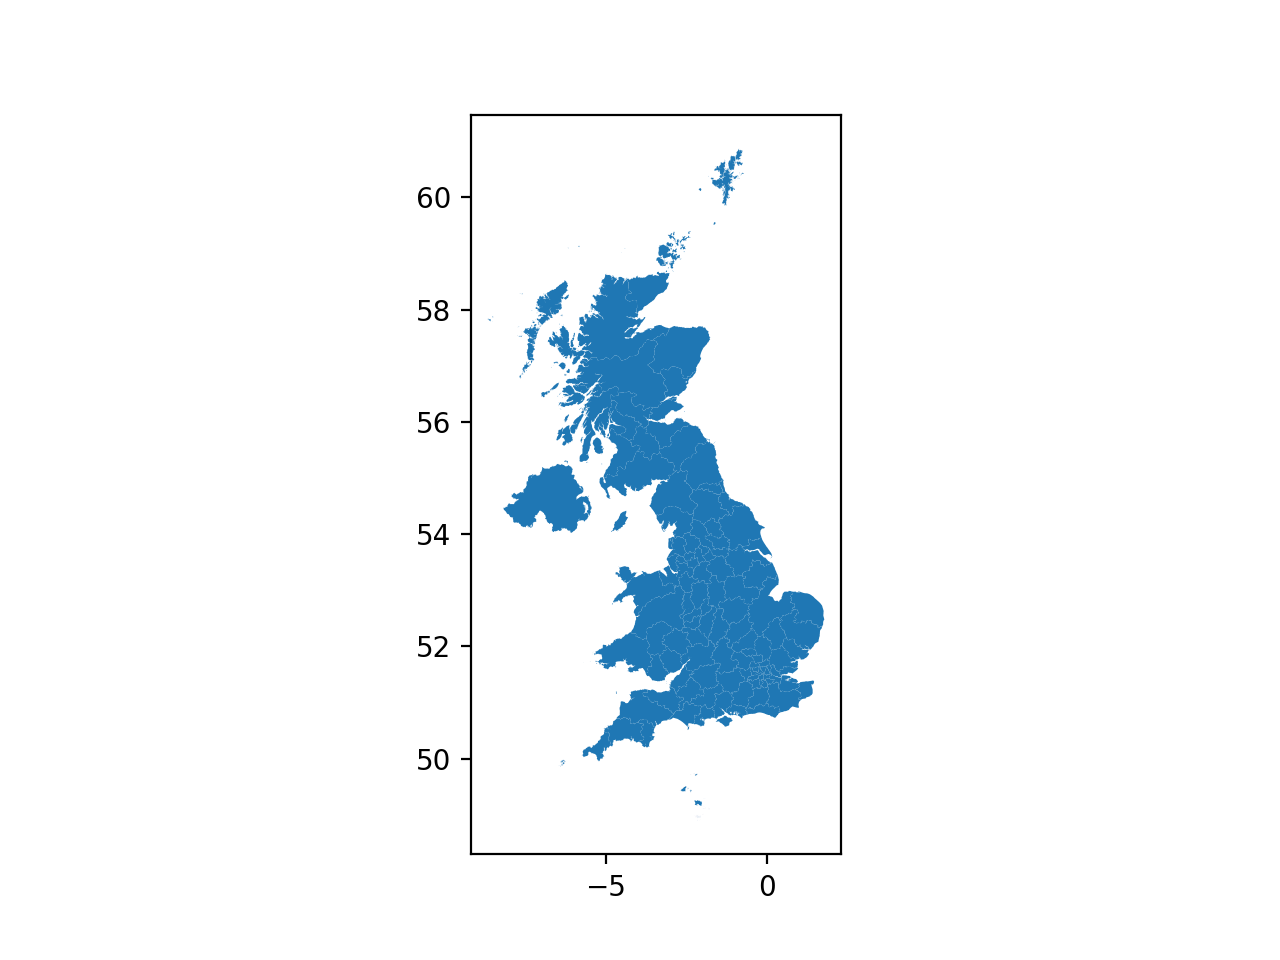

<AxesSubplot: >

In [51]:
#Load and check map of PostCode Areas
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()


In [52]:
#Aggregate postcodes with total containers for the year
aggregate_district = north_east[(north_east.Mode.str.match('|'.join(['S-TRUCK', 'C-TRUCK']))) & (north_east.Port.str.match('|'.join(['GBFXSTM', 'GBLGPTM'])))].groupby(["PC_Area"])["Units"].sum().reset_index()
aggregate_district['Units'] = aggregate_district['Units'] / 8 * 12
aggregate_district

,PC_Area,Units
0,BD,672.0
1,DE,2121.0
2,DH,57.0
3,DL,52.5
4,DN,2280.0
5,HD,144.0
6,HG,57.0
7,HU,135.0
8,HX,94.5
9,LN,64.5


In [53]:
reset_index = map_df_areas.set_index("name")
merged = reset_index.join(aggregate_district.set_index("PC_Area"))
merged["Units"] = merged["Units"].fillna(0)
merged

,geometry,Units
name,,
AB,"POLYGON ((-2.21091 56.88580, -2.21858 56.88676...",0.0
AL,"POLYGON ((-0.37138 51.68730, -0.37227 51.68781...",0.0
B,"POLYGON ((-2.05436 52.24756, -2.05530 52.25006...",0.0
BA,"POLYGON ((-2.08430 51.31717, -2.08008 51.31421...",0.0
BB,"POLYGON ((-2.21557 53.73160, -2.21541 53.73145...",0.0
...,...,...
ZE,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",0.0
BT,"MULTIPOLYGON (((-5.54258 54.29000, -5.54922 54...",0.0
GY,"MULTIPOLYGON (((-2.36625 49.40170, -2.36750 49...",0.0


<IPython.core.display.Javascript object>


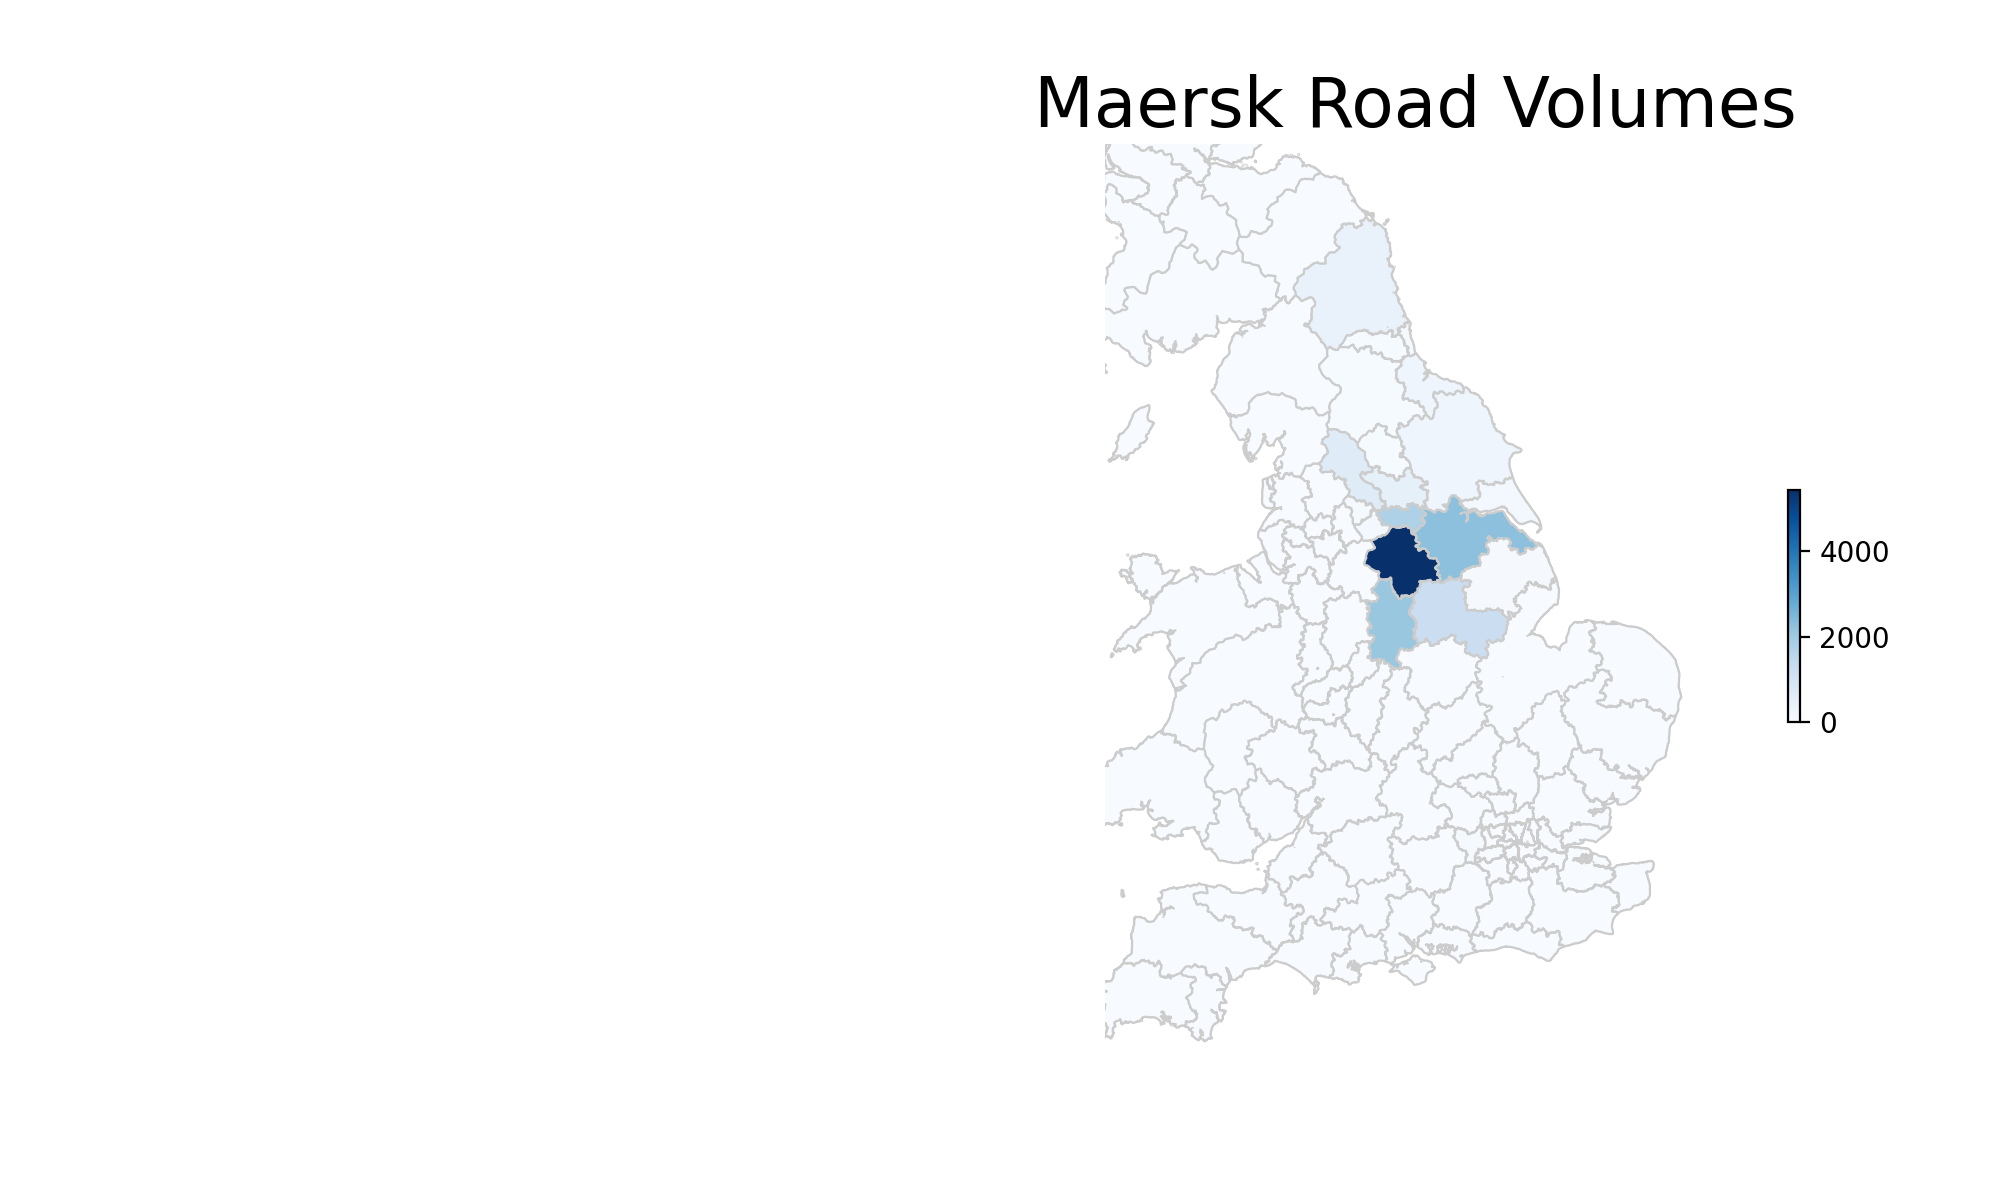

/var/folders/4r/y80n195n7bzf_nd0xqdjksd80000gn/T/ipykernel_47744/3112953247.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


<AxesSubplot: title={'center': 'Maersk Road Volumes'}>

In [54]:
variable = "Units"
vmin, vmax = 0, merged.Units.max()
fig, ax = plt.subplots(1, figsize=(10, 6))

# add a title and remove axis
ax.set_title("Maersk Road Volumes", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)

merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
